# Notebook 2 -- Clustering K-means et Classification Ascendante Hierarchique (CAH)

## Objectif

Ce notebook applique les deux methodes de clustering utilisees dans le paper de reference 
aux donnees ESG de notre panel d'entreprises technologiques :

1. **K-means** : partitionnement en k groupes minimisant l'inertie intra-cluster
2. **CAH (clustering hierarchique agglomeratif)** : construction bottom-up d'une hierarchie de clusters

On applique ces methodes sur deux jeux de variables :
- Les **niveaux absolus** des scores (Environmental, Social, ESG global)
- Les **variations annuelles** des scores (delta sur 12 mois)

## Pre-requis

Executer le Notebook 1 au prealable pour generer les donnees nettoyees dans `data/clean/`.

---
## 1. Imports et chargement des donnees

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_style('whitegrid')

TICKER_NAMES = {
    'NVDA US Equity': 'NVIDIA', 'AVGO US Equity': 'Broadcom',
    'TSM US Equity': 'TSMC', 'GOOGL US Equity': 'Alphabet',
    '000660 KS Equity': 'SK Hynix', 'LRCX US Equity': 'Lam Research',
    '6857 JP Equity': 'Advantest', 'TSEM IT Equity': 'Tower Semi',
    'MSFT US Equity': 'Microsoft', 'LITE US Equity': 'Lumentum',
    'AMD US Equity': 'AMD', 'FN US Equity': 'Fabrinet',
    'SNOW US Equity': 'Snowflake', 'MU US Equity': 'Micron',
    'TSLA US Equity': 'Tesla', '9984 JP Equity': 'SoftBank',
    'CRDO US Equity': 'CREDO Tech', 'ENR GR Equity': 'Siemens Energy',
    'MPWR US Equity': 'Monolithic Power', '2383 TT Equity': 'Elite Material',
    'CLS CN Equity': 'Celestica', 'META US Equity': 'Meta',
    'AMZN US Equity': 'Amazon'
}

print('Imports effectues.')

Imports effectues.


In [5]:
# Chargement des donnees nettoyees
df_env = pd.read_csv('../data/clean/notebook1/env_score_clean.csv', parse_dates=['Date'])
df_soc = pd.read_csv('../data/clean/notebook1/soc_score_clean.csv', parse_dates=['Date'])
df_esg = pd.read_csv('../data/clean/notebook1/esg_score_clean.csv', parse_dates=['Date'])

df_env_var = pd.read_csv('../data/clean/notebook1/env_score_variations.csv', parse_dates=['Date'])
df_soc_var = pd.read_csv('../data/clean/notebook1/soc_score_variations.csv', parse_dates=['Date'])
df_esg_var = pd.read_csv('../data/clean/notebook1/esg_score_variations.csv', parse_dates=['Date'])

df_panel = pd.read_csv('../data/clean/notebook1/panel_complet.csv', parse_dates=['Date'])

print(f"Panel charge : {df_panel.shape[0]} observations, {df_panel['Ticker'].nunique()} entreprises")

Panel charge : 2196 observations, 18 entreprises


---
## 2. Preparation des donnees pour le clustering

### Choix de la representation

Pour appliquer le clustering, il faut construire une matrice **entreprises x variables**. 
Plusieurs approches sont possibles :

1. **Coupe transversale** : utiliser les scores a une date donnee (ex: derniere observation)
2. **Moyennes temporelles** : moyenner les scores sur toute la periode
3. **Multi-periodes** : utiliser les scores de plusieurs periodes comme variables

Nous appliquons les trois approches. L'approche par moyennes est la plus robuste au bruit 
ponctuel et sera notre approche principale.

### Standardisation

La standardisation (centrage-reduction) est indispensable avant K-means car cet algorithme 
utilise la distance euclidienne, qui est sensible aux echelles. Meme si les trois scores BESG 
sont sur la meme echelle [0, 10], leurs distributions peuvent differer significativement.

In [6]:
def preparer_matrice_clustering(df_env, df_soc, df_esg, methode='moyenne'):
    """
    Prepare la matrice entreprises x variables pour le clustering.
    
    Parametres
    ----------
    df_env, df_soc, df_esg : pd.DataFrame
        DataFrames en format wide (Date + colonnes de scores).
    methode : str
        'moyenne' : moyenne sur toute la periode
        'derniere' : derniere observation disponible
        'mediane' : mediane sur toute la periode
    
    Retourne
    --------
    pd.DataFrame
        Matrice entreprises x variables (Env, Soc, ESG).
    """
    score_cols = [c for c in df_env.columns if c != 'Date']
    
    if methode == 'moyenne':
        env_vals = df_env[score_cols].mean()
        soc_vals = df_soc[score_cols].mean()
        esg_vals = df_esg[score_cols].mean()
    elif methode == 'derniere':
        env_vals = df_env[score_cols].iloc[-1]
        soc_vals = df_soc[score_cols].iloc[-1]
        esg_vals = df_esg[score_cols].iloc[-1]
    elif methode == 'mediane':
        env_vals = df_env[score_cols].median()
        soc_vals = df_soc[score_cols].median()
        esg_vals = df_esg[score_cols].median()
    else:
        raise ValueError(f"Methode inconnue : {methode}")
    
    mat = pd.DataFrame({
        'Env_Score': env_vals,
        'Soc_Score': soc_vals,
        'ESG_Score': esg_vals
    })
    
    mat.index.name = 'Ticker'
    mat['Entreprise'] = mat.index.map(TICKER_NAMES)
    
    # Supprimer les entreprises avec trop de NA (moins de 50% d'observations)
    mat = mat.dropna(thresh=3)  # Au moins les 3 scores disponibles
    
    return mat


# Preparation avec la methode des moyennes
mat_moyenne = preparer_matrice_clustering(df_env, df_soc, df_esg, methode='moyenne')
mat_derniere = preparer_matrice_clustering(df_env, df_soc, df_esg, methode='derniere')

print(f"Matrice de clustering (moyennes) : {mat_moyenne.shape[0]} entreprises x 3 variables")
print(f"Matrice de clustering (derniere obs) : {mat_derniere.shape[0]} entreprises x 3 variables")
print("\nApercu (moyennes) :")
mat_moyenne.round(3)

Matrice de clustering (moyennes) : 23 entreprises x 3 variables
Matrice de clustering (derniere obs) : 23 entreprises x 3 variables

Apercu (moyennes) :


,Env_Score,Soc_Score,ESG_Score,Entreprise
Ticker,,,,
NVDA US Equity,6.770,5.966,6.500,NVIDIA
AVGO US Equity,2.342,1.967,3.325,Broadcom
TSM US Equity,4.080,4.457,4.604,TSMC
GOOGL US Equity,4.449,1.851,3.589,Alphabet
000660 KS Equity,3.914,2.900,4.098,SK Hynix
LRCX US Equity,5.110,3.391,5.225,Lam Research
6857 JP Equity,6.572,4.570,5.835,Advantest
TSEM IT Equity,1.552,1.895,2.848,Tower Semi
MSFT US Equity,5.954,2.160,4.749,Microsoft


In [7]:
# Standardisation
features = ['Env_Score', 'Soc_Score', 'ESG_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(mat_moyenne[features])
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=mat_moyenne.index)

print("Donnees standardisees (moyenne=0, ecart-type=1) :")
print(f"  Moyennes apres standardisation : {X_scaled.mean(axis=0).round(6)}")
print(f"  Ecarts-types apres standardisation : {X_scaled.std(axis=0).round(6)}")
print("\nApercu :")
X_scaled_df.head()

Donnees standardisees (moyenne=0, ecart-type=1) :
  Moyennes apres standardisation : [ 0. -0.  0.]
  Ecarts-types apres standardisation : [1. 1. 1.]

Apercu :


,Env_Score,Soc_Score,ESG_Score
Ticker,,,
NVDA US Equity,1.585504,2.243286,2.034145
AVGO US Equity,-0.752304,-0.688820,-0.542844
TSM US Equity,0.165475,1.136822,0.495072
GOOGL US Equity,0.360028,-0.774184,-0.328394
000660 KS Equity,0.077891,-0.005189,0.084936


---
## 3. K-means : determination du nombre optimal de clusters

Le choix du nombre de clusters k est un probleme central en analyse de clustering. 
Nous utilisons trois criteres complementaires :

1. **Methode du coude (Elbow)** : on trace l'inertie intra-cluster (WCSS) en fonction de k et on cherche le "coude" ou la decroissance ralentit
2. **Score de silhouette** : mesure de la coherence des clusters, entre -1 (mauvais) et +1 (excellent)
3. **Indice de Calinski-Harabasz** : ratio variance inter/intra-cluster, a maximiser
4. **Indice de Davies-Bouldin** : mesure de separation entre clusters, a minimiser

In [8]:
# Calcul des metriques pour k = 2 a 10
K_range = range(2, min(11, len(X_scaled)))  # Pas plus de clusters que d'observations

inertias = []
silhouettes = []
calinski = []
davies_bouldin = []

for k in K_range:
    km = KMeans(n_clusters=k, n_init=50, max_iter=500, random_state=42)
    labels = km.fit_predict(X_scaled)
    
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski.append(calinski_harabasz_score(X_scaled, labels))
    davies_bouldin.append(davies_bouldin_score(X_scaled, labels))

print("Metriques calculees pour k = 2 a", max(K_range))

Metriques calculees pour k = 2 a 10


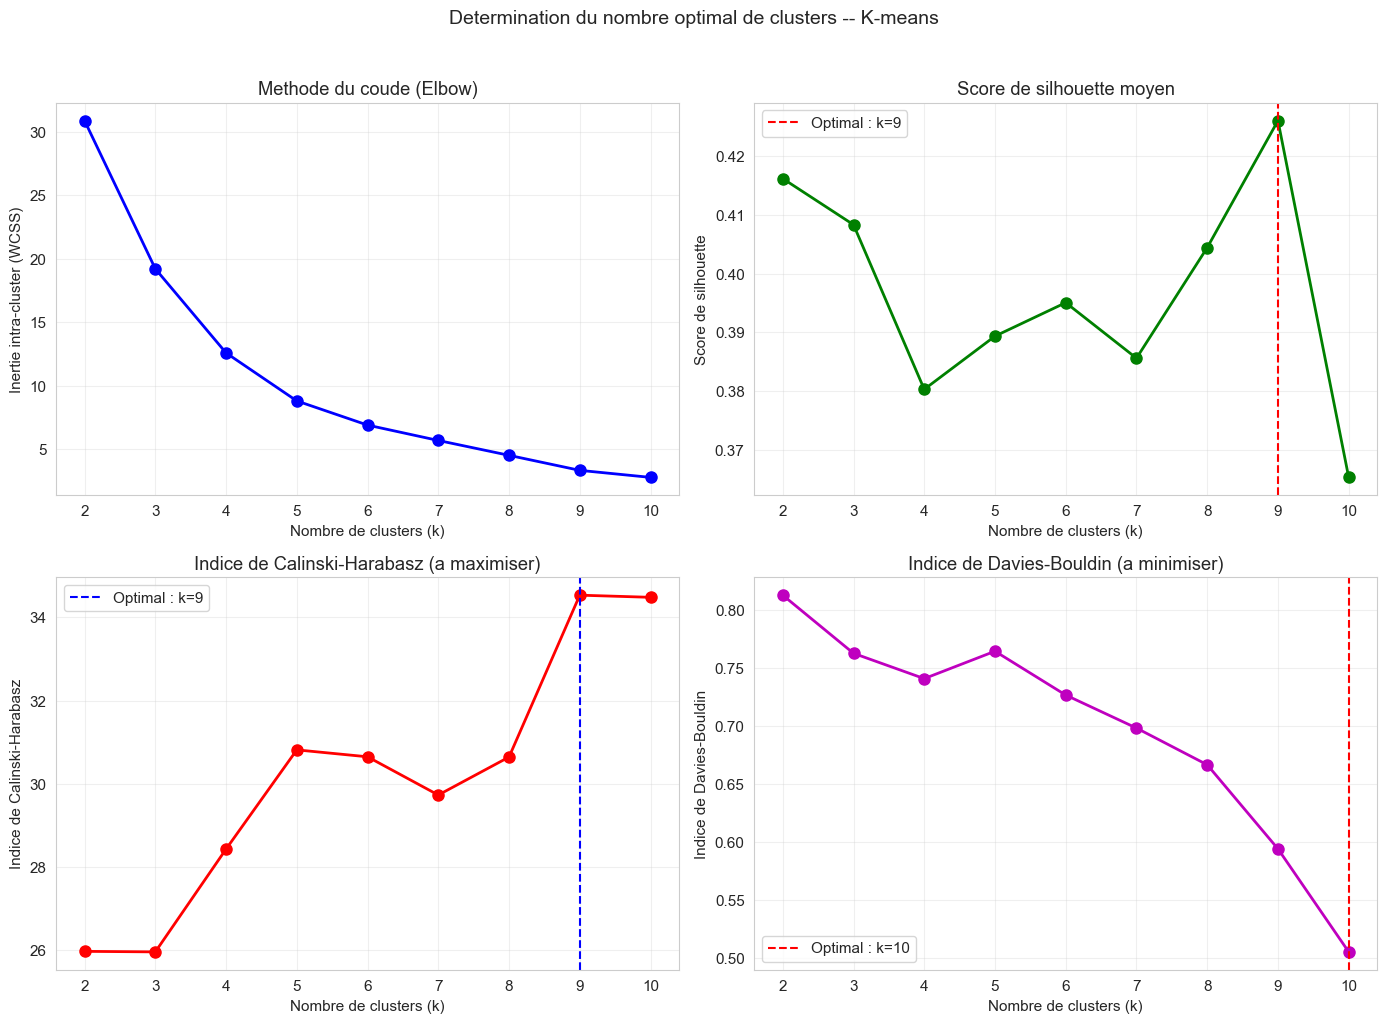


Resume des k optimaux :
  Silhouette      : k = 9 (score = 0.426)
  Calinski-Harabasz: k = 9 (score = 34.5)
  Davies-Bouldin  : k = 10 (score = 0.505)


In [9]:
# Visualisation des 4 criteres
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow
axes[0, 0].plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Nombre de clusters (k)')
axes[0, 0].set_ylabel('Inertie intra-cluster (WCSS)')
axes[0, 0].set_title('Methode du coude (Elbow)')
axes[0, 0].set_xticks(list(K_range))

# Silhouette
axes[0, 1].plot(list(K_range), silhouettes, 'go-', linewidth=2, markersize=8)
best_k_sil = list(K_range)[np.argmax(silhouettes)]
axes[0, 1].axvline(x=best_k_sil, color='red', linestyle='--', 
                    label=f'Optimal : k={best_k_sil}')
axes[0, 1].set_xlabel('Nombre de clusters (k)')
axes[0, 1].set_ylabel('Score de silhouette')
axes[0, 1].set_title('Score de silhouette moyen')
axes[0, 1].set_xticks(list(K_range))
axes[0, 1].legend()

# Calinski-Harabasz
axes[1, 0].plot(list(K_range), calinski, 'ro-', linewidth=2, markersize=8)
best_k_ch = list(K_range)[np.argmax(calinski)]
axes[1, 0].axvline(x=best_k_ch, color='blue', linestyle='--', 
                    label=f'Optimal : k={best_k_ch}')
axes[1, 0].set_xlabel('Nombre de clusters (k)')
axes[1, 0].set_ylabel('Indice de Calinski-Harabasz')
axes[1, 0].set_title('Indice de Calinski-Harabasz (a maximiser)')
axes[1, 0].set_xticks(list(K_range))
axes[1, 0].legend()

# Davies-Bouldin
axes[1, 1].plot(list(K_range), davies_bouldin, 'mo-', linewidth=2, markersize=8)
best_k_db = list(K_range)[np.argmin(davies_bouldin)]
axes[1, 1].axvline(x=best_k_db, color='red', linestyle='--', 
                    label=f'Optimal : k={best_k_db}')
axes[1, 1].set_xlabel('Nombre de clusters (k)')
axes[1, 1].set_ylabel('Indice de Davies-Bouldin')
axes[1, 1].set_title('Indice de Davies-Bouldin (a minimiser)')
axes[1, 1].set_xticks(list(K_range))
axes[1, 1].legend()

plt.suptitle('Determination du nombre optimal de clusters -- K-means', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../notebooks/figures/02_optimal_k.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nResume des k optimaux :")
print(f"  Silhouette      : k = {best_k_sil} (score = {max(silhouettes):.3f})")
print(f"  Calinski-Harabasz: k = {best_k_ch} (score = {max(calinski):.1f})")
print(f"  Davies-Bouldin  : k = {best_k_db} (score = {min(davies_bouldin):.3f})")

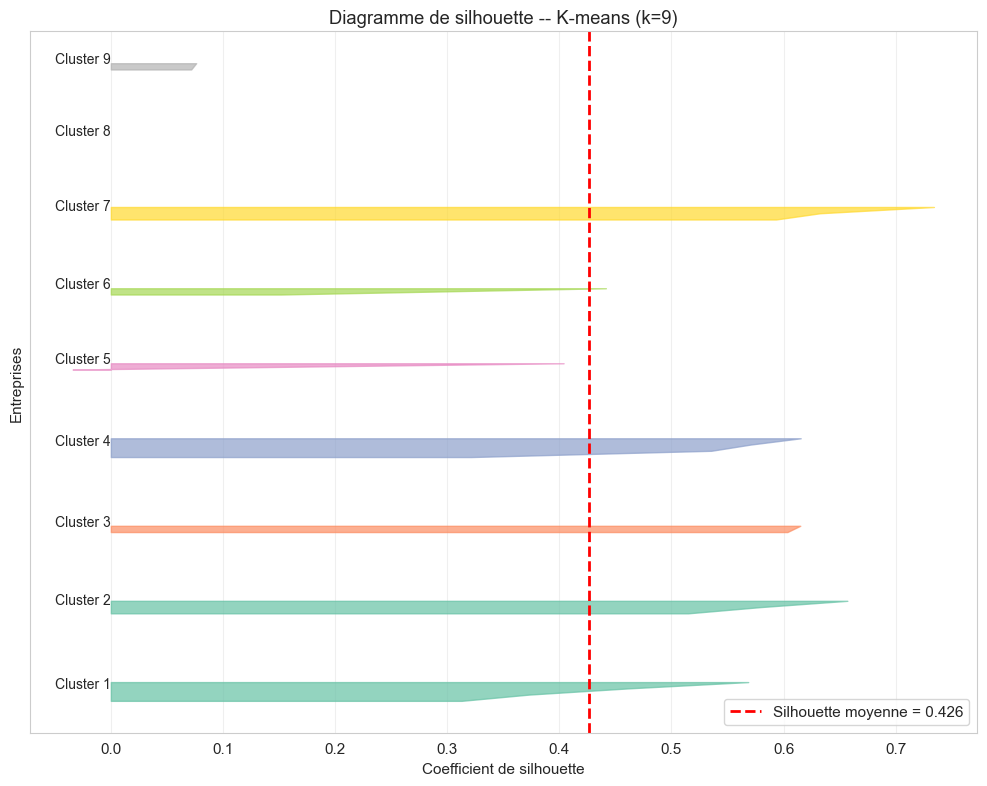

In [10]:
# Diagramme de silhouette detaille pour le k optimal
from matplotlib.cm import get_cmap

k_optimal = best_k_sil  # On retient le k maximisant la silhouette

km_final = KMeans(n_clusters=k_optimal, n_init=50, max_iter=500, random_state=42)
labels_km = km_final.fit_predict(X_scaled)

# Calcul des silhouettes individuelles
sil_values = silhouette_samples(X_scaled, labels_km)
sil_avg = silhouette_score(X_scaled, labels_km)

fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10
cmap = get_cmap('Set2')

for i in range(k_optimal):
    cluster_sil = sil_values[labels_km == i]
    cluster_sil.sort()
    y_upper = y_lower + len(cluster_sil)
    
    color = cmap(i / k_optimal)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_sil), f'Cluster {i+1}', fontsize=10)
    y_lower = y_upper + 10

ax.axvline(x=sil_avg, color='red', linestyle='--', linewidth=2,
           label=f'Silhouette moyenne = {sil_avg:.3f}')
ax.set_xlabel('Coefficient de silhouette')
ax.set_ylabel('Entreprises')
ax.set_title(f'Diagramme de silhouette -- K-means (k={k_optimal})')
ax.legend(loc='lower right')
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../notebooks/figures/02_silhouette_diagram.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Application du K-means avec le k optimal

On applique K-means avec le nombre de clusters determine precedemment et on examine 
la composition de chaque cluster.

In [11]:
# Ajout des labels au DataFrame
mat_moyenne['Cluster_KM'] = labels_km + 1  # Clusters 1, 2, ..., k

# Composition des clusters
print(f"=== Resultats K-means (k = {k_optimal}) ===\n")

for c in sorted(mat_moyenne['Cluster_KM'].unique()):
    members = mat_moyenne[mat_moyenne['Cluster_KM'] == c]
    print(f"--- Cluster {c} ({len(members)} entreprises) ---")
    for _, row in members.iterrows():
        print(f"  {row['Entreprise']:20s}  Env={row['Env_Score']:.2f}  Soc={row['Soc_Score']:.2f}  ESG={row['ESG_Score']:.2f}")
    print(f"  [Moyennes] Env={members['Env_Score'].mean():.2f}  Soc={members['Soc_Score'].mean():.2f}  ESG={members['ESG_Score'].mean():.2f}")
    print()

=== Resultats K-means (k = 9) ===

--- Cluster 1 (4 entreprises) ---
  Broadcom              Env=2.34  Soc=1.97  ESG=3.32
  SoftBank              Env=3.42  Soc=1.92  ESG=3.08
  Monolithic Power      Env=2.55  Soc=2.11  ESG=3.22
  Amazon                Env=2.90  Soc=2.54  ESG=3.57
  [Moyennes] Env=2.80  Soc=2.13  ESG=3.30

--- Cluster 2 (3 entreprises) ---
  NVIDIA                Env=6.77  Soc=5.97  ESG=6.50
  Advantest             Env=6.57  Soc=4.57  ESG=5.83
  AMD                   Env=6.85  Soc=4.73  ESG=6.30
  [Moyennes] Env=6.73  Soc=5.09  ESG=6.21

--- Cluster 3 (2 entreprises) ---
  Snowflake             Env=0.00  Soc=1.46  ESG=1.88
  CREDO Tech            Env=0.74  Soc=1.15  ESG=1.94
  [Moyennes] Env=0.37  Soc=1.30  ESG=1.91

--- Cluster 4 (4 entreprises) ---
  TSMC                  Env=4.08  Soc=4.46  ESG=4.60
  Micron                Env=3.85  Soc=4.79  ESG=5.15
  Tesla                 Env=3.11  Soc=4.32  ESG=4.08
  Celestica             Env=3.97  Soc=4.17  ESG=4.69
  [Moyennes

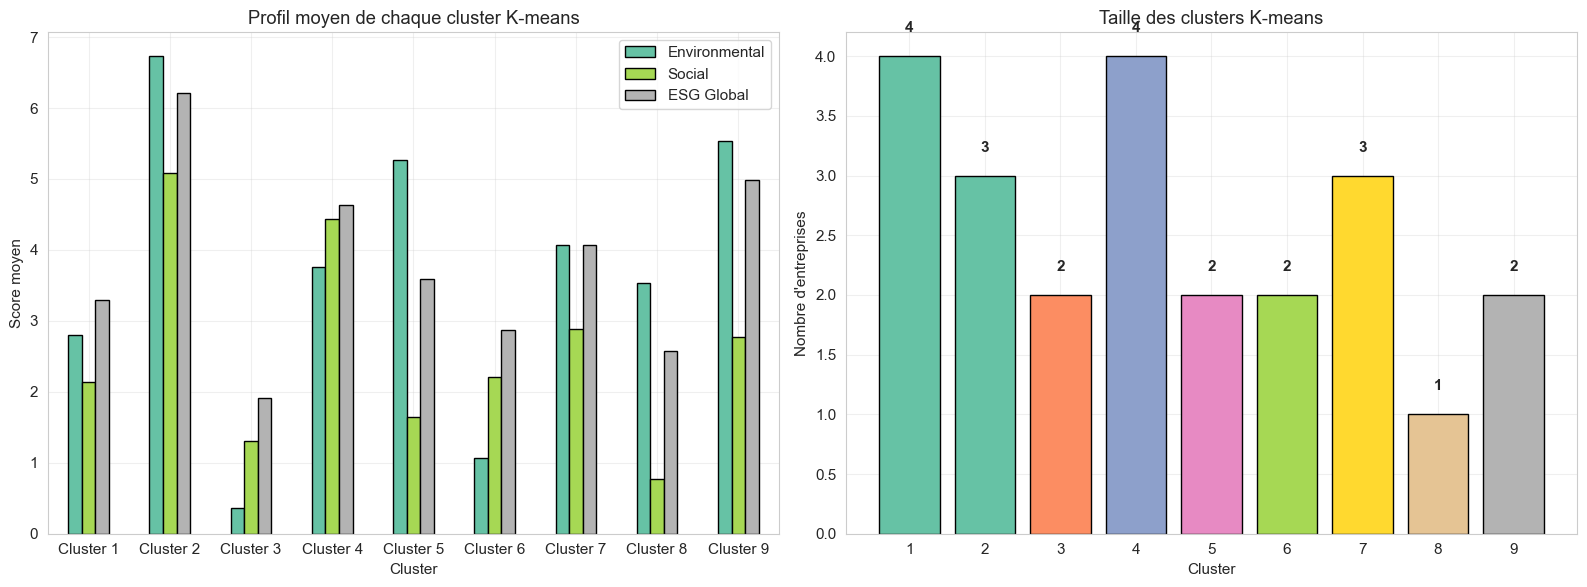

In [12]:
# Profil moyen de chaque cluster (radar chart / bar chart)
cluster_profiles = mat_moyenne.groupby('Cluster_KM')[features].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart des profils
cluster_profiles.plot(kind='bar', ax=axes[0], colormap='Set2', edgecolor='black')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Score moyen')
axes[0].set_title('Profil moyen de chaque cluster K-means')
axes[0].set_xticklabels([f'Cluster {i}' for i in cluster_profiles.index], rotation=0)
axes[0].legend(['Environmental', 'Social', 'ESG Global'])

# Taille des clusters
sizes = mat_moyenne['Cluster_KM'].value_counts().sort_index()
axes[1].bar(sizes.index, sizes.values, color=[get_cmap('Set2')(i/k_optimal) for i in range(k_optimal)],
            edgecolor='black')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Nombre d\'entreprises')
axes[1].set_title('Taille des clusters K-means')
axes[1].set_xticks(sizes.index)

for i, v in enumerate(sizes.values):
    axes[1].text(sizes.index[i], v + 0.2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/02_kmeans_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

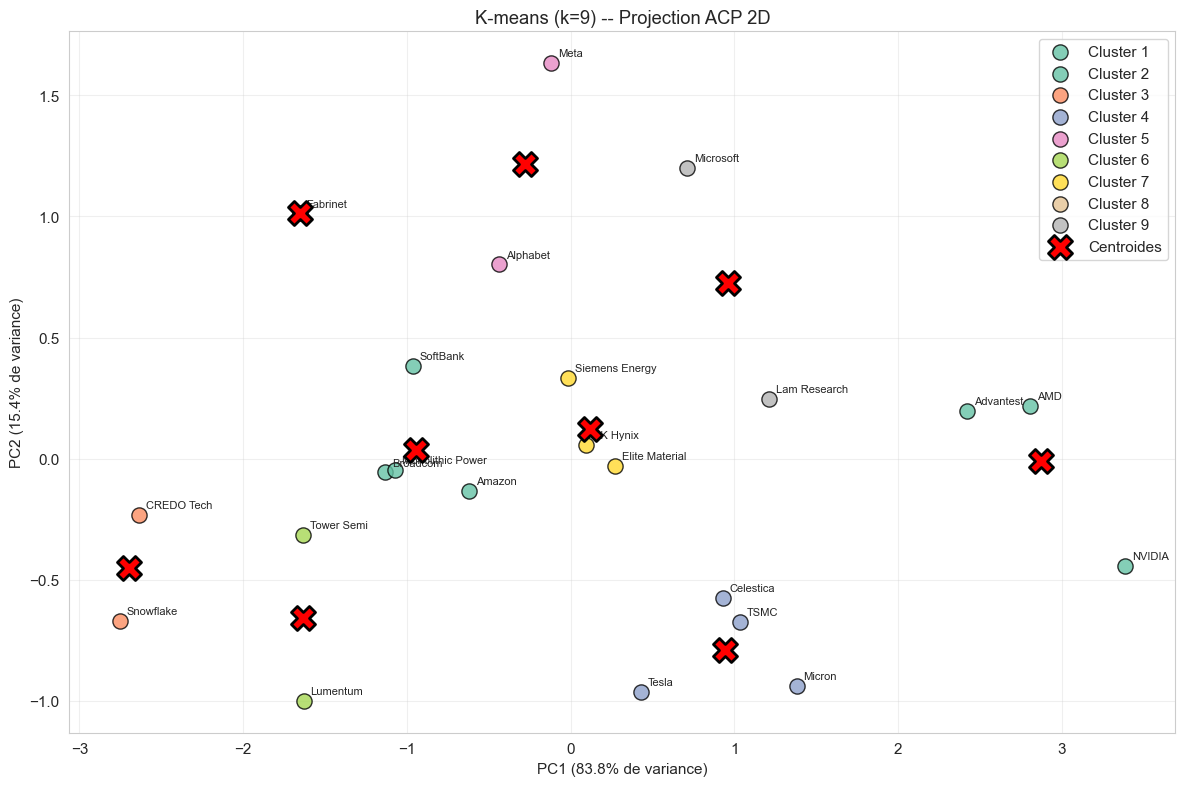

Variance expliquee par les 2 composantes : 99.2%


In [13]:
# Visualisation 2D des clusters (projection sur les deux premieres composantes principales)
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = get_cmap('Set2')

for c in sorted(mat_moyenne['Cluster_KM'].unique()):
    mask = mat_moyenne['Cluster_KM'].values == c
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[cmap((c-1)/k_optimal)], label=f'Cluster {c}', s=120,
               edgecolors='black', linewidth=1, alpha=0.8)

# Annotation des points
entreprises = mat_moyenne['Entreprise'].values
for i, name in enumerate(entreprises):
    ax.annotate(name, (X_pca[i, 0], X_pca[i, 1]),
                textcoords='offset points', xytext=(5, 5), fontsize=8)

# Centroides projetes
centroids_pca = pca_2d.transform(km_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidth=2, label='Centroides', zorder=5)

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% de variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% de variance)')
ax.set_title(f'K-means (k={k_optimal}) -- Projection ACP 2D')
ax.legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/02_kmeans_pca2d.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Variance expliquee par les 2 composantes : {pca_2d.explained_variance_ratio_.sum()*100:.1f}%")

---
## 5. Classification Ascendante Hierarchique (CAH)

La CAH est une methode de clustering hierarchique qui construit une hierarchie de clusters 
par fusions successives. Contrairement au K-means, elle ne necessite pas de specifier k a priori 
et produit un dendrogramme qui permet de visualiser la structure hierarchique des donnees.

### Choix du critere de lien (linkage)

Nous testons quatre criteres de lien :
- **Ward** : minimise l'augmentation de l'inertie intra-cluster (le plus utilise)
- **Complete** : distance maximale entre paires de points de deux clusters
- **Average** : distance moyenne entre paires de points
- **Single** : distance minimale (sensible au phenomene de chaining)

In [14]:
# Calcul des 4 types de linkage
linkage_methods = ['ward', 'complete', 'average', 'single']
linkage_results = {}

for method in linkage_methods:
    Z = linkage(X_scaled, method=method, metric='euclidean')
    linkage_results[method] = Z

print("Matrices de lien calculees pour :", linkage_methods)

Matrices de lien calculees pour : ['ward', 'complete', 'average', 'single']


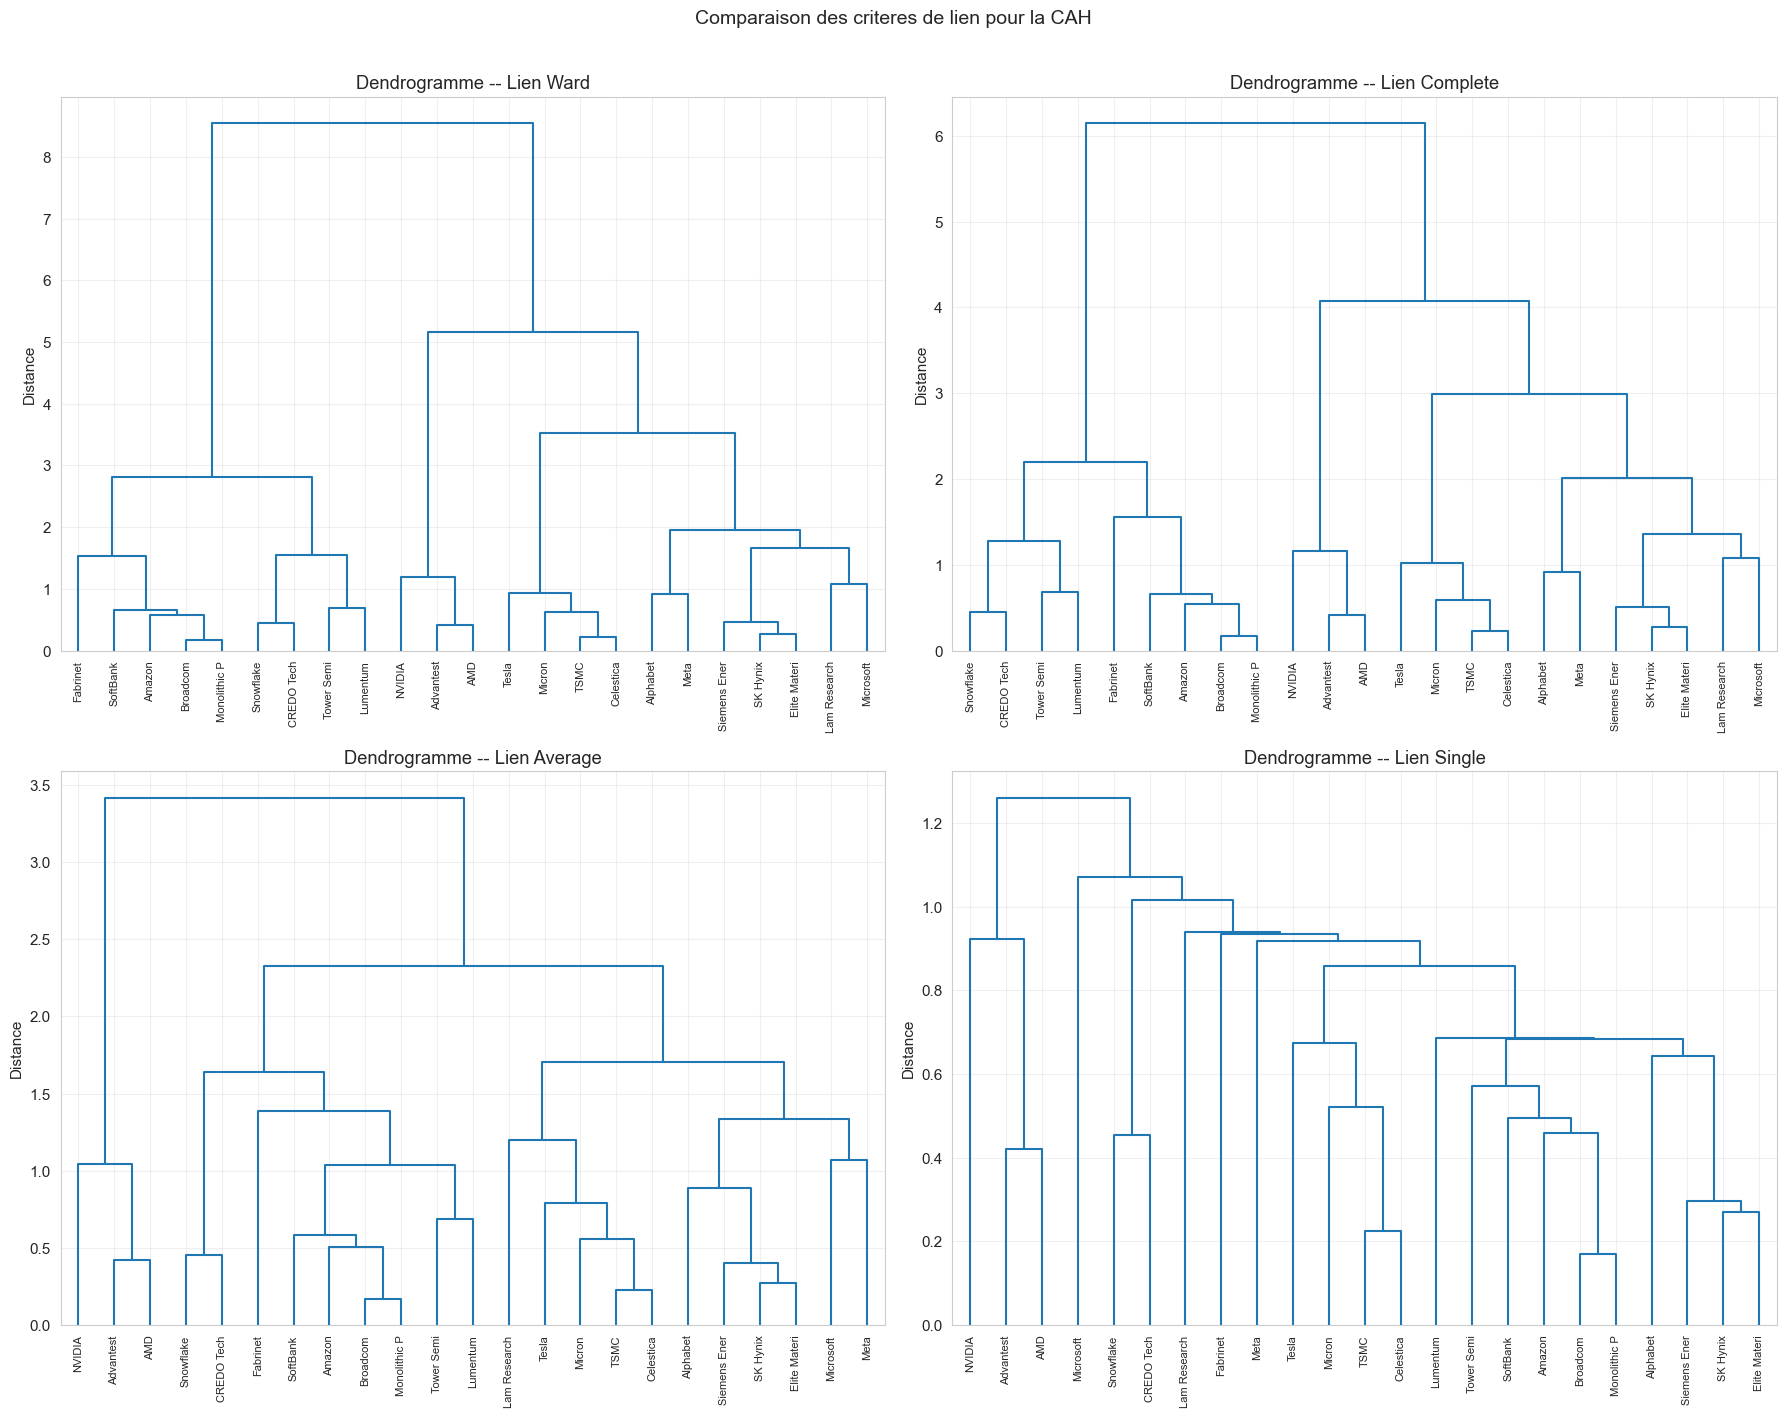

In [15]:
# Dendrogrammes comparatifs
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

short_labels = [TICKER_NAMES.get(t, t)[:12] for t in mat_moyenne.index]

for ax, method in zip(axes.flat, linkage_methods):
    dendrogram(linkage_results[method], labels=short_labels,
               leaf_rotation=90, leaf_font_size=8, ax=ax,
               color_threshold=0)
    ax.set_title(f'Dendrogramme -- Lien {method.capitalize()}')
    ax.set_ylabel('Distance')

plt.suptitle('Comparaison des criteres de lien pour la CAH', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../notebooks/figures/02_dendrogrammes_comparaison.png', dpi=150, bbox_inches='tight')
plt.show()

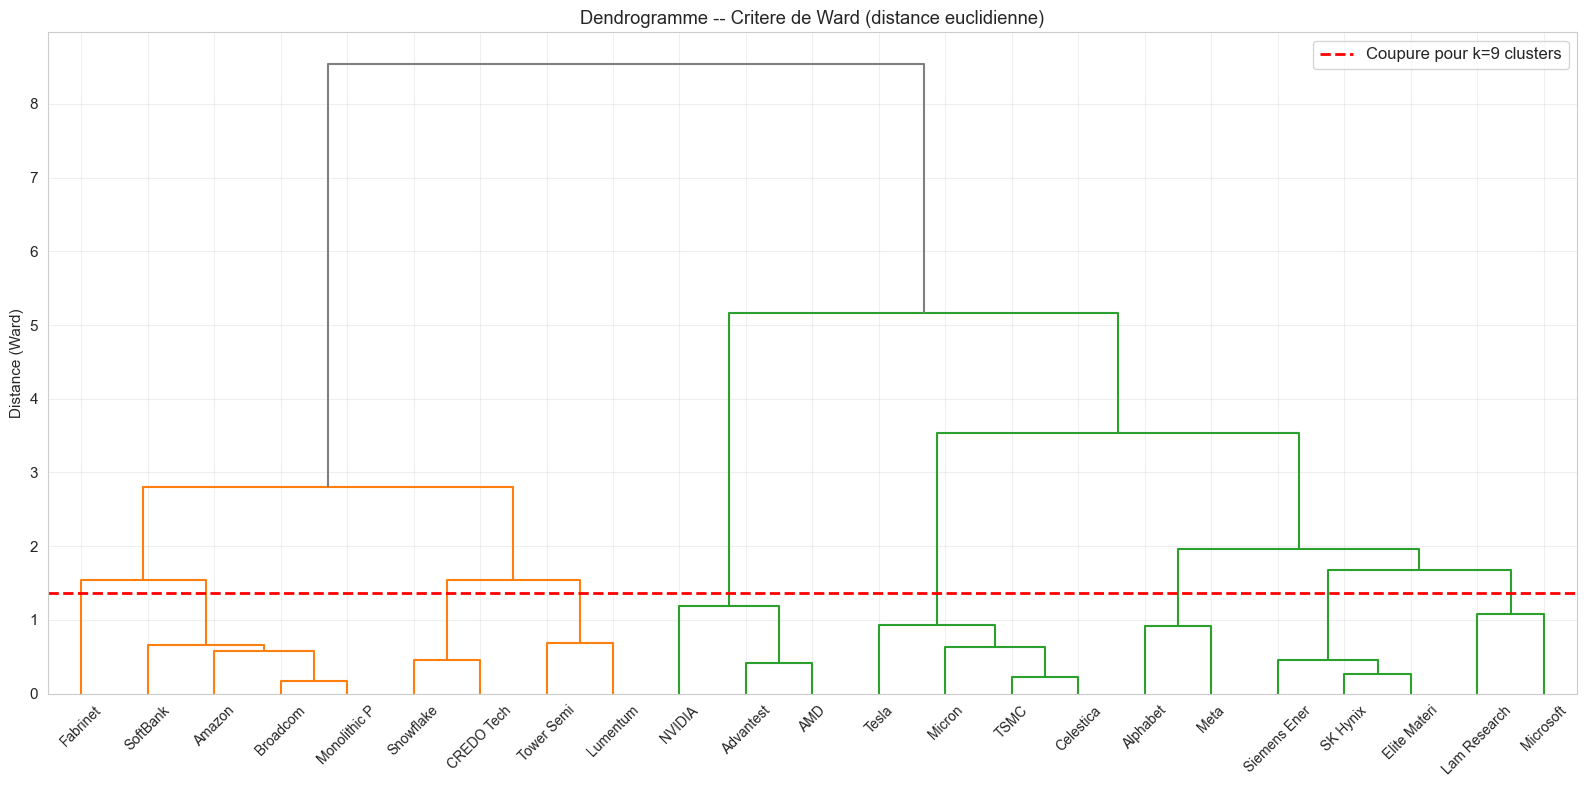

In [16]:
# Dendrogramme detaille avec le critere de Ward (reference)
fig, ax = plt.subplots(figsize=(16, 8))

Z_ward = linkage_results['ward']

dend = dendrogram(Z_ward, labels=short_labels, leaf_rotation=45, 
                  leaf_font_size=10, ax=ax, above_threshold_color='gray')

# Ligne de coupure pour k clusters
# On determine le seuil de coupure pour avoir k_optimal clusters
# La hauteur de coupure est entre les (n-k)-ieme et (n-k+1)-ieme fusions
n = len(X_scaled)
if k_optimal < n:
    threshold = (Z_ward[-(k_optimal), 2] + Z_ward[-(k_optimal-1), 2]) / 2
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
               label=f'Coupure pour k={k_optimal} clusters')

ax.set_ylabel('Distance (Ward)')
ax.set_title('Dendrogramme -- Critere de Ward (distance euclidienne)')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('../notebooks/figures/02_dendrogramme_ward.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Application de la CAH avec le critere de Ward
labels_cah = fcluster(Z_ward, t=k_optimal, criterion='maxclust')

mat_moyenne['Cluster_CAH'] = labels_cah

print(f"=== Resultats CAH Ward (k = {k_optimal}) ===\n")

for c in sorted(mat_moyenne['Cluster_CAH'].unique()):
    members = mat_moyenne[mat_moyenne['Cluster_CAH'] == c]
    print(f"--- Cluster {c} ({len(members)} entreprises) ---")
    for _, row in members.iterrows():
        print(f"  {row['Entreprise']:20s}  Env={row['Env_Score']:.2f}  Soc={row['Soc_Score']:.2f}  ESG={row['ESG_Score']:.2f}")
    print(f"  [Moyennes] Env={members['Env_Score'].mean():.2f}  Soc={members['Soc_Score'].mean():.2f}  ESG={members['ESG_Score'].mean():.2f}")
    print()

=== Resultats CAH Ward (k = 9) ===

--- Cluster 1 (4 entreprises) ---
  Broadcom              Env=2.34  Soc=1.97  ESG=3.32
  SoftBank              Env=3.42  Soc=1.92  ESG=3.08
  Monolithic Power      Env=2.55  Soc=2.11  ESG=3.22
  Amazon                Env=2.90  Soc=2.54  ESG=3.57
  [Moyennes] Env=2.80  Soc=2.13  ESG=3.30

--- Cluster 2 (1 entreprises) ---
  Fabrinet              Env=3.53  Soc=0.78  ESG=2.58
  [Moyennes] Env=3.53  Soc=0.78  ESG=2.58

--- Cluster 3 (2 entreprises) ---
  Snowflake             Env=0.00  Soc=1.46  ESG=1.88
  CREDO Tech            Env=0.74  Soc=1.15  ESG=1.94
  [Moyennes] Env=0.37  Soc=1.30  ESG=1.91

--- Cluster 4 (2 entreprises) ---
  Tower Semi            Env=1.55  Soc=1.89  ESG=2.85
  Lumentum              Env=0.59  Soc=2.52  ESG=2.90
  [Moyennes] Env=1.07  Soc=2.21  ESG=2.87

--- Cluster 5 (3 entreprises) ---
  NVIDIA                Env=6.77  Soc=5.97  ESG=6.50
  Advantest             Env=6.57  Soc=4.57  ESG=5.83
  AMD                   Env=6.85  Soc=4

In [18]:
# Score de silhouette pour la CAH
sil_cah = silhouette_score(X_scaled, labels_cah)
ch_cah = calinski_harabasz_score(X_scaled, labels_cah)
db_cah = davies_bouldin_score(X_scaled, labels_cah)

print(f"Metriques de qualite (CAH Ward, k={k_optimal}) :")
print(f"  Silhouette        : {sil_cah:.3f}")
print(f"  Calinski-Harabasz : {ch_cah:.1f}")
print(f"  Davies-Bouldin    : {db_cah:.3f}")

Metriques de qualite (CAH Ward, k=9) :
  Silhouette        : 0.426
  Calinski-Harabasz : 34.5
  Davies-Bouldin    : 0.594


---
## 6. Comparaison K-means vs CAH

On compare les deux methodes en termes de :
- Concordance des affectations (quelles entreprises changent de cluster ?)
- Metriques de qualite
- Stabilite des resultats

In [19]:
# Tableau de contingence K-means vs CAH
contingence = pd.crosstab(
    mat_moyenne['Cluster_KM'].rename('K-means'),
    mat_moyenne['Cluster_CAH'].rename('CAH'),
    margins=True
)
print("Tableau de contingence K-means vs CAH :")
print(contingence.to_string())

# Indice de Rand ajuste (mesure de concordance)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_km, labels_cah)
nmi = normalized_mutual_info_score(labels_km, labels_cah)

print(f"\nIndice de Rand ajuste (ARI) : {ari:.3f}")
print(f"Information mutuelle normalisee (NMI) : {nmi:.3f}")
print("\nInterpretation :")
print("  ARI=1 : accord parfait, ARI=0 : assignation aleatoire")
print("  NMI=1 : accord parfait, NMI=0 : independance totale")

Tableau de contingence K-means vs CAH :
CAH      1  2  3  4  5  6  7  8  9  All
K-means                                
1        4  0  0  0  0  0  0  0  0    4
2        0  0  0  0  3  0  0  0  0    3
3        0  0  2  0  0  0  0  0  0    2
4        0  0  0  0  0  4  0  0  0    4
5        0  0  0  0  0  0  2  0  0    2
6        0  0  0  2  0  0  0  0  0    2
7        0  0  0  0  0  0  0  3  0    3
8        0  1  0  0  0  0  0  0  0    1
9        0  0  0  0  0  0  0  0  2    2
All      4  1  2  2  3  4  2  3  2   23

Indice de Rand ajuste (ARI) : 1.000
Information mutuelle normalisee (NMI) : 1.000

Interpretation :
  ARI=1 : accord parfait, ARI=0 : assignation aleatoire
  NMI=1 : accord parfait, NMI=0 : independance totale


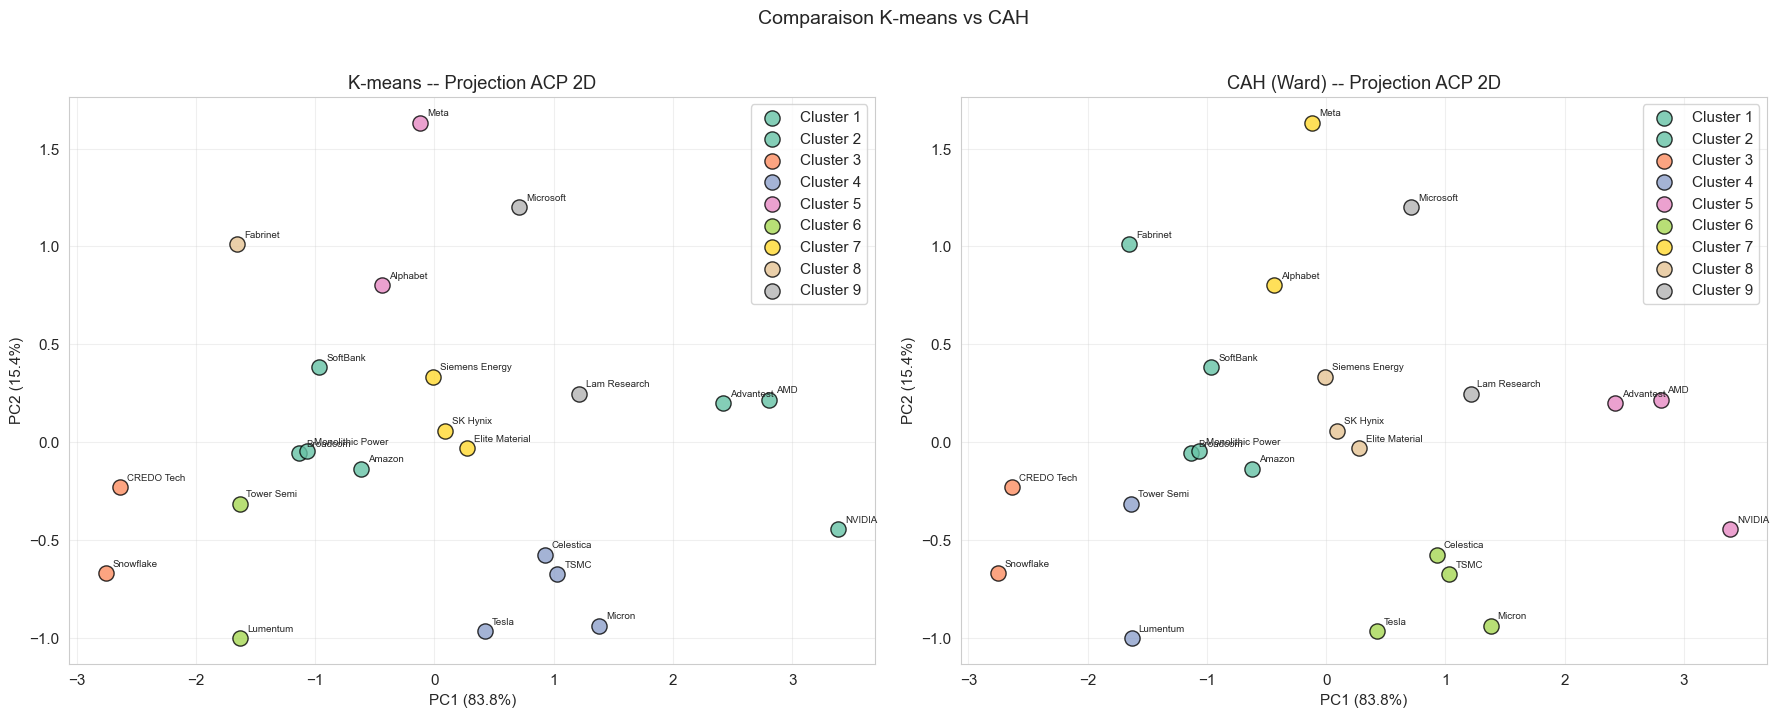

In [20]:
# Comparaison visuelle (projection PCA)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
cmap = get_cmap('Set2')

for ax, (labels, titre) in zip(axes, [
    (mat_moyenne['Cluster_KM'].values, 'K-means'),
    (mat_moyenne['Cluster_CAH'].values, 'CAH (Ward)')
]):
    for c in sorted(np.unique(labels)):
        mask = labels == c
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[cmap((c-1)/k_optimal)], label=f'Cluster {c}', s=120,
                   edgecolors='black', linewidth=1, alpha=0.8)
    
    for i, name in enumerate(mat_moyenne['Entreprise'].values):
        ax.annotate(name, (X_pca[i, 0], X_pca[i, 1]),
                    textcoords='offset points', xytext=(5, 5), fontsize=7)
    
    ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(f'{titre} -- Projection ACP 2D')
    ax.legend()

plt.suptitle('Comparaison K-means vs CAH', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../notebooks/figures/02_comparaison_kmeans_cah.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Tableau comparatif des metriques
sil_km = silhouette_score(X_scaled, labels_km)
ch_km = calinski_harabasz_score(X_scaled, labels_km)
db_km = davies_bouldin_score(X_scaled, labels_km)

comparaison = pd.DataFrame({
    'K-means': [sil_km, ch_km, db_km],
    'CAH (Ward)': [sil_cah, ch_cah, db_cah]
}, index=['Silhouette (max)', 'Calinski-Harabasz (max)', 'Davies-Bouldin (min)'])

print("\nComparaison des metriques de qualite :")
print(comparaison.round(3).to_string())

# Identification de la meilleure methode par metrique
print("\nMeilleure methode par critere :")
print(f"  Silhouette        : {'K-means' if sil_km >= sil_cah else 'CAH'}")
print(f"  Calinski-Harabasz : {'K-means' if ch_km >= ch_cah else 'CAH'}")
print(f"  Davies-Bouldin    : {'K-means' if db_km <= db_cah else 'CAH'}")


Comparaison des metriques de qualite :
                         K-means  CAH (Ward)
Silhouette (max)           0.426       0.426
Calinski-Harabasz (max)   34.535      34.535
Davies-Bouldin (min)       0.594       0.594

Meilleure methode par critere :
  Silhouette        : K-means
  Calinski-Harabasz : K-means
  Davies-Bouldin    : K-means


---
## 7. Analyse des clusters sur les variations annuelles

Comme dans le paper, on applique egalement le clustering sur les variations annuelles 
plutot que sur les niveaux. Cela permet de regrouper les entreprises non pas par leur 
score absolu, mais par leur dynamique d'amelioration/degradation ESG.

In [22]:
# Preparation de la matrice de variations moyennes
score_cols_env = [c for c in df_env_var.columns if c != 'Date']
score_cols_soc = [c for c in df_soc_var.columns if c != 'Date']
score_cols_esg = [c for c in df_esg_var.columns if c != 'Date']

mat_var = pd.DataFrame({
    'Env_Var': df_env_var[score_cols_env].mean(),
    'Soc_Var': df_soc_var[score_cols_soc].mean(),
    'ESG_Var': df_esg_var[score_cols_esg].mean()
})
mat_var['Entreprise'] = mat_var.index.map(TICKER_NAMES)
mat_var = mat_var.dropna(thresh=3)

# Standardisation
features_var = ['Env_Var', 'Soc_Var', 'ESG_Var']
scaler_var = StandardScaler()
X_var_scaled = scaler_var.fit_transform(mat_var[features_var])

print(f"Matrice de variations : {mat_var.shape[0]} entreprises x 3 variables")
mat_var[features_var + ['Entreprise']].round(4)

Matrice de variations : 23 entreprises x 3 variables


,Env_Var,Soc_Var,ESG_Var,Entreprise
NVDA US Equity,0.0716,0.3358,0.1266,NVIDIA
AVGO US Equity,0.5952,0.1368,0.3516,Broadcom
TSM US Equity,0.1244,0.2945,0.1560,TSMC
GOOGL US Equity,0.1364,0.2018,0.1636,Alphabet
000660 KS Equity,0.1604,0.0491,0.1298,SK Hynix
LRCX US Equity,0.1038,0.0992,0.0623,Lam Research
6857 JP Equity,0.2120,0.5495,0.3735,Advantest
TSEM IT Equity,0.3251,0.2433,0.2531,Tower Semi
MSFT US Equity,-0.1073,0.2769,0.1188,Microsoft
LITE US Equity,0.1165,0.3483,0.2353,Lumentum


Nombre optimal de clusters (variations) : k = 5 (silhouette = 0.383)


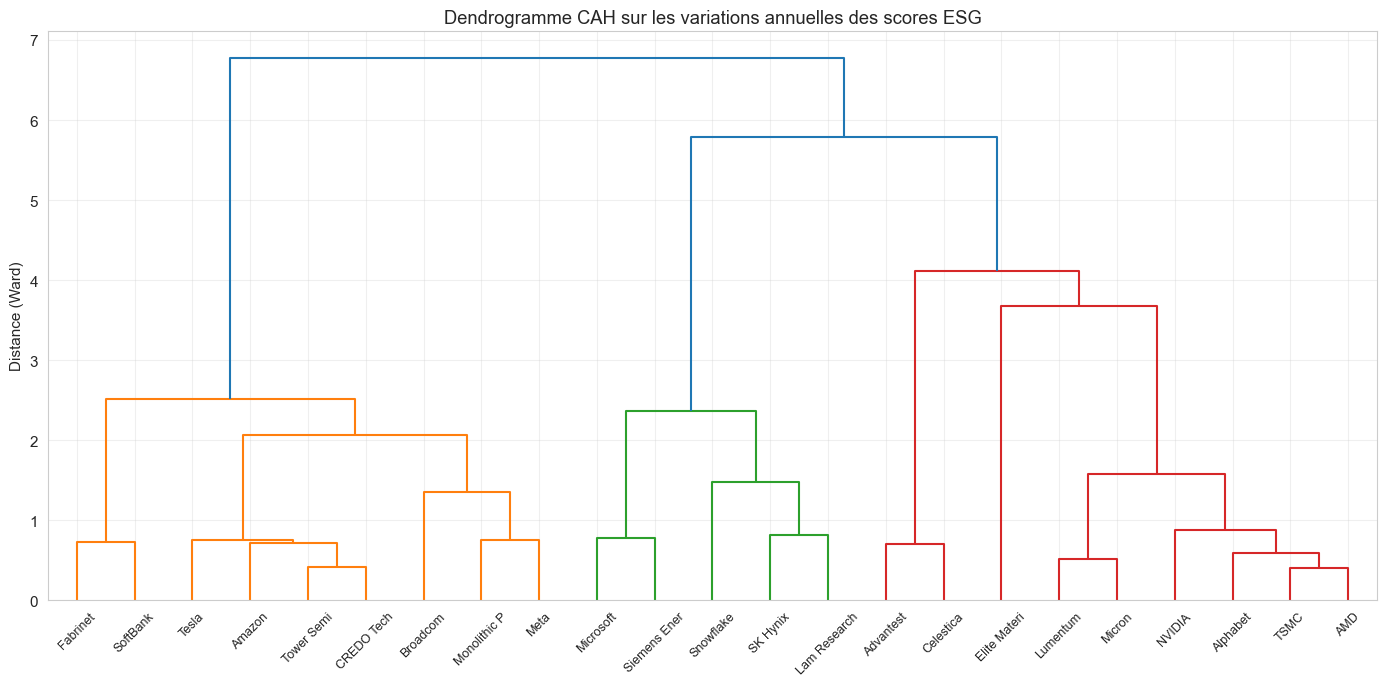

In [23]:
# K-means sur les variations
K_range_var = range(2, min(8, len(X_var_scaled)))
sil_var = []
for k in K_range_var:
    km_v = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels_v = km_v.fit_predict(X_var_scaled)
    sil_var.append(silhouette_score(X_var_scaled, labels_v))

k_opt_var = list(K_range_var)[np.argmax(sil_var)]
print(f"Nombre optimal de clusters (variations) : k = {k_opt_var} (silhouette = {max(sil_var):.3f})")

# Application
km_var = KMeans(n_clusters=k_opt_var, n_init=50, random_state=42)
mat_var['Cluster_Var_KM'] = km_var.fit_predict(X_var_scaled) + 1

# CAH sur les variations
Z_var = linkage(X_var_scaled, method='ward')
mat_var['Cluster_Var_CAH'] = fcluster(Z_var, t=k_opt_var, criterion='maxclust')

# Dendrogramme
fig, ax = plt.subplots(figsize=(14, 7))
short_labels_var = [TICKER_NAMES.get(t, t)[:12] for t in mat_var.index]
dendrogram(Z_var, labels=short_labels_var, leaf_rotation=45, leaf_font_size=9, ax=ax)
ax.set_ylabel('Distance (Ward)')
ax.set_title('Dendrogramme CAH sur les variations annuelles des scores ESG')

plt.tight_layout()
plt.savefig('../notebooks/figures/02_dendrogramme_variations.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
# Composition des clusters (variations)
print(f"\n=== Clusters sur les variations annuelles (K-means, k={k_opt_var}) ===\n")
for c in sorted(mat_var['Cluster_Var_KM'].unique()):
    members = mat_var[mat_var['Cluster_Var_KM'] == c]
    print(f"--- Cluster {c} ({len(members)} entreprises) ---")
    for _, row in members.iterrows():
        print(f"  {row['Entreprise']:20s}  dEnv={row['Env_Var']:+.3f}  dSoc={row['Soc_Var']:+.3f}  dESG={row['ESG_Var']:+.3f}")
    print()


=== Clusters sur les variations annuelles (K-means, k=5) ===

--- Cluster 1 (2 entreprises) ---
  Advantest             dEnv=+0.212  dSoc=+0.550  dESG=+0.373
  Celestica             dEnv=+0.344  dSoc=+0.511  dESG=+0.348

--- Cluster 2 (7 entreprises) ---
  NVIDIA                dEnv=+0.072  dSoc=+0.336  dESG=+0.127
  TSMC                  dEnv=+0.124  dSoc=+0.295  dESG=+0.156
  Alphabet              dEnv=+0.136  dSoc=+0.202  dESG=+0.164
  Microsoft             dEnv=-0.107  dSoc=+0.277  dESG=+0.119
  Lumentum              dEnv=+0.117  dSoc=+0.348  dESG=+0.235
  AMD                   dEnv=+0.157  dSoc=+0.280  dESG=+0.191
  Micron                dEnv=+0.179  dSoc=+0.419  dESG=+0.223

--- Cluster 3 (9 entreprises) ---
  Broadcom              dEnv=+0.595  dSoc=+0.137  dESG=+0.352
  Tower Semi            dEnv=+0.325  dSoc=+0.243  dESG=+0.253
  Fabrinet              dEnv=+0.393  dSoc=+0.055  dESG=+0.142
  Tesla                 dEnv=+0.324  dSoc=+0.205  dESG=+0.216
  SoftBank              dEn

---
## 8. Stabilite du K-means (sensibilite a l'initialisation)

Le K-means est sensible a l'initialisation des centroides. Pour evaluer la stabilite 
de nos resultats, on execute l'algorithme 100 fois avec des initialisations differentes 
et on mesure la concordance des partitions obtenues.

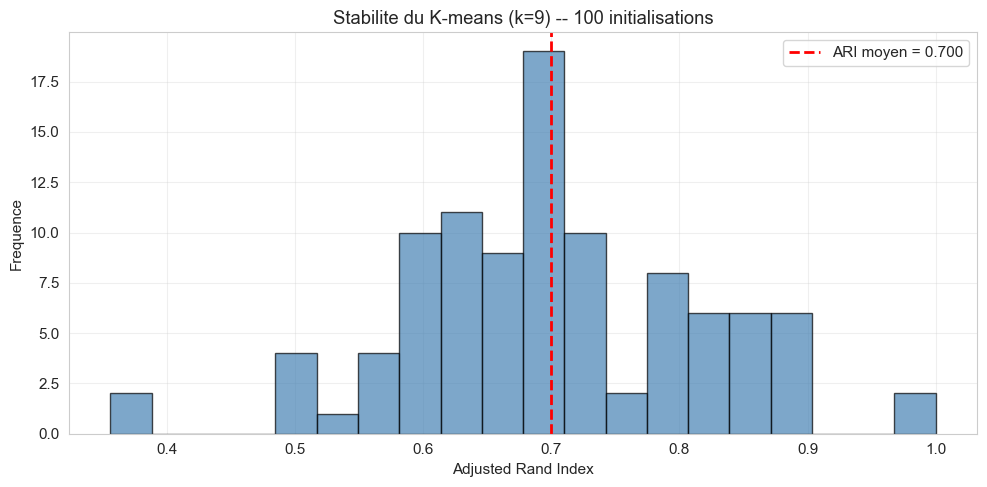

ARI moyen : 0.700 (+/- 0.118)
Proportion de runs avec ARI > 0.9 : 2%


In [25]:
# Test de stabilite
n_runs = 100
ari_scores = []
ref_labels = KMeans(n_clusters=k_optimal, n_init=50, random_state=42).fit_predict(X_scaled)

for seed in range(n_runs):
    km_test = KMeans(n_clusters=k_optimal, n_init=1, random_state=seed)
    test_labels = km_test.fit_predict(X_scaled)
    ari_scores.append(adjusted_rand_score(ref_labels, test_labels))

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ari_scores, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=np.mean(ari_scores), color='red', linestyle='--', linewidth=2,
           label=f'ARI moyen = {np.mean(ari_scores):.3f}')
ax.set_xlabel('Adjusted Rand Index')
ax.set_ylabel('Frequence')
ax.set_title(f'Stabilite du K-means (k={k_optimal}) -- {n_runs} initialisations')
ax.legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/02_stabilite_kmeans.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"ARI moyen : {np.mean(ari_scores):.3f} (+/- {np.std(ari_scores):.3f})")
print(f"Proportion de runs avec ARI > 0.9 : {100 * np.mean(np.array(ari_scores) > 0.9):.0f}%")

---
## 9. Sauvegarde des resultats

On sauvegarde les affectations de cluster pour les reutiliser dans le Notebook 3.

In [26]:
import os
os.makedirs('../data/clean/notebook2', exist_ok=True)

# Sauvegarde des resultats de clustering (niveaux)
mat_moyenne.to_csv('../data/clean/notebook2/clustering_niveaux.csv')

# Sauvegarde des resultats de clustering (variations)
mat_var.to_csv('../data/clean/notebook2/clustering_variations.csv')

# Sauvegarde des donnees standardisees
X_scaled_df.to_csv('../data/clean/notebook2/scores_standardises.csv')

print("Resultats sauvegardes dans data/clean/notebook2/")
print("  - clustering_niveaux.csv")
print("  - clustering_variations.csv")
print("  - scores_standardises.csv")

Resultats sauvegardes dans data/clean/notebook2/
  - clustering_niveaux.csv
  - clustering_variations.csv
  - scores_standardises.csv


---
## Synthese du Notebook 2

### Methodes appliquees
- **K-means** avec determination du k optimal via silhouette, Calinski-Harabasz et Davies-Bouldin
- **CAH** avec comparaison de 4 criteres de lien (Ward, Complete, Average, Single)
- Clustering sur **niveaux absolus** et sur **variations annuelles**

### Principaux resultats
- Le nombre optimal de clusters et les metriques de qualite seront visibles a l'execution
- La concordance K-means/CAH (ARI) permet de juger de la robustesse de la structure identifiee
- L'analyse de stabilite du K-means montre la sensibilite a l'initialisation

### Limites identifiees (a adresser dans le Notebook 3)
- K-means suppose des clusters spheriques (hypothese forte)
- Pas de reduction de dimension prealable (ACP)
- Distance euclidienne uniquement
- Pas d'analyse temporelle (les clusters sont statiques)
- Pas de methodes alternatives (DBSCAN, GMM)